In [1]:
from collections import OrderedDict

import numpy as np
import sympy as sm

import matplotlib.pyplot as plt
import matplotlib.animation as animation

from opty.direct_collocation import Problem

In [2]:
%matplotlib notebook

In [3]:
sm.init_printing()

# Equations of motion

In [4]:
# Symbolic equations of motion
I, m, g, d, t = sm.symbols('I, m, g, d, t')
theta, omega, T = sm.symbols('theta, omega, T', cls=sm.Function)

state_symbols = (theta(t), omega(t))
constant_symbols = (I, m, g, d)
specified_symbols = (T(t),)

eom = sm.Matrix([theta(t).diff() - omega(t),
                 I * omega(t).diff() + m * g * d * sm.sin(theta(t)) - T(t)])

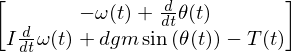

In [5]:
eom

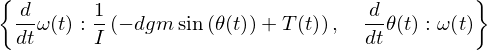

In [6]:
sm.solve(eom, theta(t).diff(t), omega(t).diff(t))

In [7]:
def rhs(x, t, I, m, g, d, coeffs):
    
    poly = np.poly1d(coeffs)
    T = poly(t)
    
    theta, omega = x
    
    thetad = omega
    omegad = (-d * m * g * np.sin(theta) + T) / I
    
    return np.array([thetad, omegad])

In [8]:
from scipy.integrate import odeint

In [9]:
times = np.linspace(0, 10, num=501)
traj = odeint(rhs, [np.pi/10, 0], times, args=(1.0, 1.0, 9.81, 1.0, np.zeros(10)))

In [10]:
%timeit traj = odeint(rhs, [np.pi/10, 0], times, args=(1.0, 1.0, 9.81, 1.0, np.random.random(10)))

765 ms ± 88.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<IPython.core.display.Javascript object>


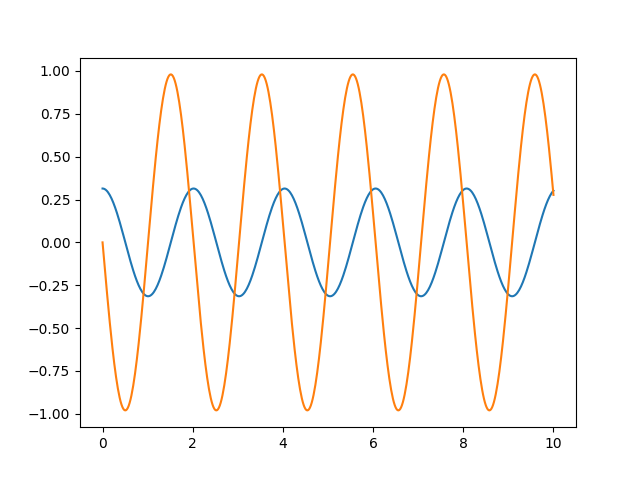

In [11]:
plt.plot(times, traj)

In [12]:
# Specify the known system parameters.
par_map = OrderedDict()
par_map[I] = 1.0
par_map[m] = 1.0
par_map[g] = 9.81
par_map[d] = 1.0

In [13]:
target_angle = np.pi
duration = 5.0
num_nodes = 1000
interval_value = duration / (num_nodes - 1)

In [14]:
# Specify the objective function and it's gradient.


def obj(free):
    """Minimize the sum of the squares of the control torque."""
    T = free[2 * num_nodes:]
    return interval_value * np.sum(T**2)


def obj_grad(free):
    grad = np.zeros_like(free)
    grad[2 * num_nodes:] = 2.0 * interval_value * free[2 * num_nodes:]
    return grad

In [15]:
# Specify the symbolic instance constraints, i.e. initial and end
# conditions.
instance_constraints = (theta(0.0),
                        theta(duration) - target_angle,
                        omega(0.0),
                        omega(duration))

In [32]:
# Create an optimization problem.
prob = Problem(obj, obj_grad, eom, state_symbols, num_nodes, interval_value,
               known_parameter_map=par_map,
               instance_constraints=instance_constraints,
               #bounds={T(t): (-2.75, 2.75)}
              )

In [33]:
%timeit prob.constraints(np.random.random(prob.num_free))

134 µs ± 549 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [34]:
%timeit prob.jacobian(np.random.random(prob.num_free))

196 µs ± 7.28 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [35]:
prob.num_free

In [36]:
# Use a random positive initial guess.
initial_guess = np.random.randn(prob.num_free)

# Find the optimal solution.
solution, info = prob.solve(initial_guess)

<IPython.core.display.Javascript object>


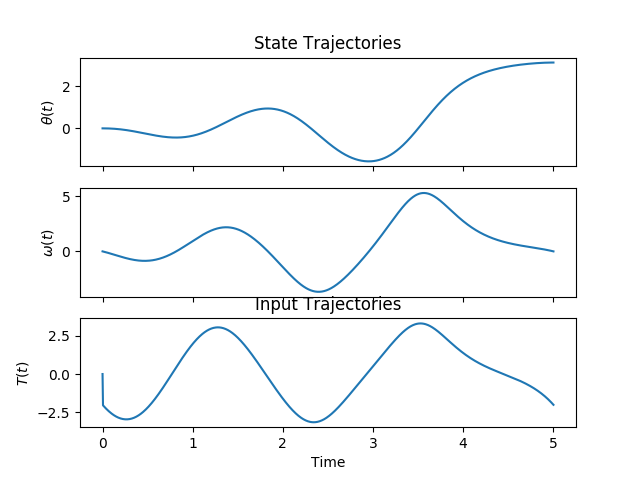

In [37]:
# Make some plots
prob.plot_trajectories(solution)

<IPython.core.display.Javascript object>


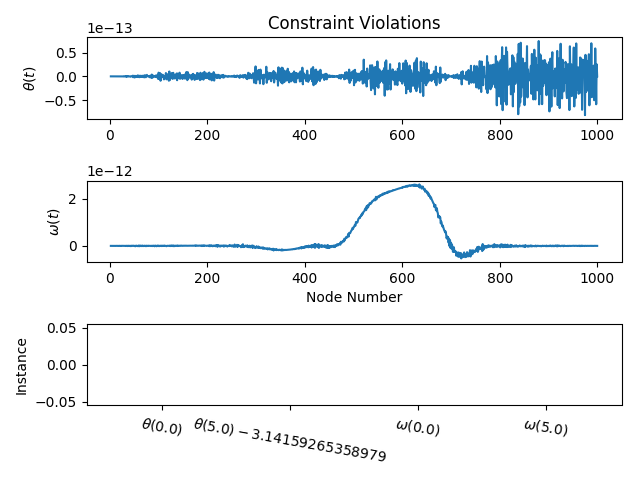

In [38]:
prob.plot_constraint_violations(solution)
plt.tight_layout()

<IPython.core.display.Javascript object>


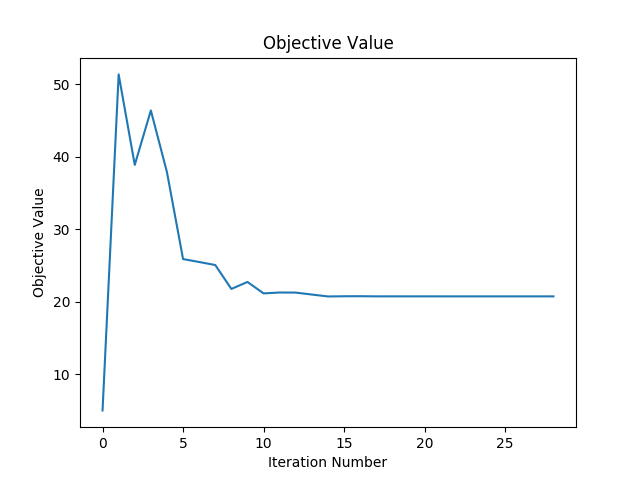

In [39]:
prob.plot_objective_value()

<IPython.core.display.Javascript object>


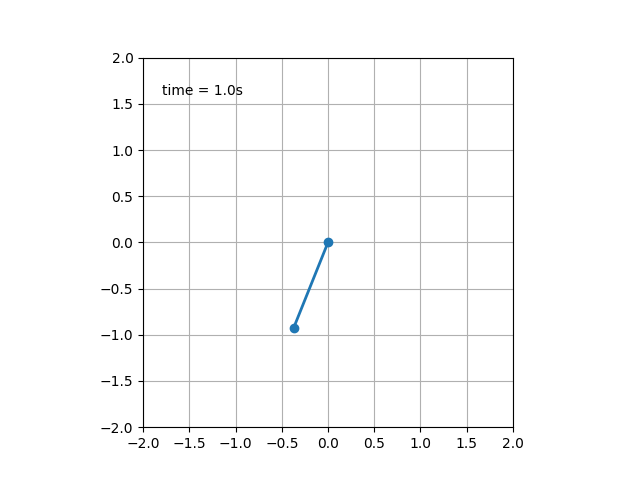

In [40]:
# Display animation

time = np.linspace(0.0, duration, num=num_nodes)
angle = solution[:num_nodes]

fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal', autoscale_on=False, xlim=(-2, 2),
                     ylim=(-2, 2))
ax.grid()

line, = ax.plot([], [], 'o-', lw=2)
time_template = 'time = {:0.1f}s'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)

def init():
    line.set_data([], [])
    time_text.set_text('')
    return line, time_text

def animate(i):
    x = [0, par_map[d] * np.sin(angle[i])]
    y = [0, -par_map[d] * np.cos(angle[i])]

    line.set_data(x, y)
    time_text.set_text(time_template.format(i * interval_value))
    return line, time_text

ani = animation.FuncAnimation(fig, animate, np.arange(1, len(time)),
                              interval=5, blit=True, init_func=init)